# Product Quantization Experiments

In [1]:
import time
import warnings
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import cdist
from scipy.stats import gaussian_kde
from matplotlib.lines import Line2D
from search_approaches import PQ, IVF, ExactSearch
from utils import *
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from IPython.display import display, Code
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [2]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
DATASET = "siftsmall" # "sift"
DIR = "siftsmall" # "sift"

In [3]:
search_data, queries, tr_data, gt = load_sift(name=DATASET, dir=DIR)
sample_query = queries[0]
sample_query_snorm = np.sum(np.square(sample_query))

print("Search vectors shape: ", search_data.shape)
print(f"Base vectors range: [{search_data.min()}, {search_data.max()}]")
print("Query vectors shape: ", queries.shape)
print("Ground truth shape: ", gt.shape)
print("Learn vectors shape: ", queries.shape)
print("Query example:\n", queries[0])

Search vectors shape:  (10000, 128)
Base vectors range: [0.0, 180.0]
Query vectors shape:  (100, 128)
Ground truth shape:  (100, 100)
Learn vectors shape:  (100, 128)
Query example:
 [  1.   3.  11. 110.  62.  22.   4.   0.  43.  21.  22.  18.   6.  28.
  64.   9.  11.   1.   0.   0.   1.  40. 101.  21.  20.   2.   4.   2.
   2.   9.  18.  35.   1.   1.   7.  25. 108. 116.  63.   2.   0.   0.
  11.  74.  40. 101. 116.   3.  33.   1.   1.  11.  14.  18. 116. 116.
  68.  12.   5.   4.   2.   2.   9. 102.  17.   3.  10.  18.   8.  15.
  67.  63.  15.   0.  14. 116.  80.   0.   2.  22.  96.  37.  28.  88.
  43.   1.   4.  18. 116.  51.   5.  11.  32.  14.   8.  23.  44.  17.
  12.   9.   0.   0.  19.  37.  85.  18.  16. 104.  22.   6.   2.  26.
  12.  58.  67.  82.  25.  12.   2.   2.  25.  18.   8.   2.  19.  42.
  48.  11.]


In [4]:
# NOTE: No vectors in search_data are equal to any vector in tr_data
# for i in range(search_data.shape[0]):
#     for j in range(tr_data.shape[0]):
#         if np.array_equal(search_data[i], tr_data[j]):
#             print(f"Row {i} in search_data is equal to row {j} in tr_data")
#             break

# matches = np.where((search_data[:, None] == tr_data).all(axis=2))

In [5]:
# data = np.concatenate([tr_data, search_data, queries], axis=0)

# pca = PCA(n_components = 2)
# data_pca = pca.fit_transform(data)
# tr_data_pca = data_pca[:len(tr_data)]
# search_data_pca = data_pca[len(tr_data):len(tr_data) + len(search_data)]
# queries_pca = data_pca[len(tr_data) + len(search_data):]

# fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
# axs[0].scatter(x=tr_data_pca[:, 0], y=tr_data_pca[:, 1], color='blue', label='Training data', edgecolors='white')
# axs[1].scatter(x=search_data_pca[:, 0], y=search_data_pca[:, 1], color='red', label='Search data', edgecolors='white')
# axs[2].scatter(x=queries_pca[:, 0], y=queries_pca[:, 1], color='green', label='Queries', edgecolors='white')

# for i in range(3):
#     axs[i].set_xlabel('PCA Dim. 1')
#     axs[i].set_ylabel('PCA Dim. 2')
#     axs[i].legend()

# plt.title("Data Visualization with PCA")
# plt.show()

# tsne = TSNE(n_components=2, perplexity=5, random_state=RANDOM_SEED)
# data_tsne = tsne.fit_transform(data)
# tr_data_tsne = data_tsne[:len(tr_data)]
# search_data_tsne = data_tsne[len(tr_data):len(tr_data) + len(search_data)]
# queries_tsne = data_tsne[len(tr_data) + len(search_data):]

# fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
# axs[0].scatter(x=tr_data_tsne[:, 0], y=tr_data_tsne[:, 1], color='blue', label='Training data', edgecolors='white')
# axs[1].scatter(x=search_data_tsne[:, 0], y=search_data_tsne[:, 1], color='red', label='Search data', edgecolors='white')
# axs[2].scatter(x=queries_tsne[:, 0], y=queries_tsne[:, 1], color='green', label='Queries', edgecolors='white')

# for i in range(3):
#     axs[i].set_xlabel('t-SNE Dim. 1')
#     axs[i].set_ylabel('t-SNE Dim. 2')
#     axs[i].legend()

# plt.title("Data Visualization with t-SNE")
# plt.show()

In [6]:
# plt.figure(figsize=(25, 5))
# plt.boxplot(tr_data);
# plt.title("Training data")
# plt.xticks([])
# plt.xlabel("Features")
# plt.figure(figsize=(25, 5))
# plt.boxplot(search_data);
# plt.title("Search data")
# plt.xticks([])
# plt.xlabel("Features")
# plt.figure(figsize=(25, 5))
# plt.boxplot(queries);
# plt.title("Queries")
# plt.xticks([])
# plt.xlabel("Features");

In [7]:
# if DATASET == "siftsmall":
#     sns.clustermap(search_data, metric='euclidean', cmap='coolwarm', method='ward', figsize=(10, 10))
#     plt.show()

In [8]:
# display PQ implementation
# file_path = 'search_approaches.py'
# with open(file_path, 'r') as file:
#     lines = file.readlines()
# selected_lines = ''.join(lines[5:151])
# display(Code(data=selected_lines, language='python'))

In [9]:
M = 8
K = 256
pq = PQ(M=M, K=K, seed=RANDOM_SEED)

print("Training the PQ quantizer...")
start_training = time.time()
pq.train(tr_data, add=False, verbose=True)
training_time = time.time() - start_training
start_adding = time.time()
pq.add(search_data)
adding_time = time.time() - start_adding

print("--------------------")
print(f"Training time: {training_time:.2f} s")
print(f"Adding time: {adding_time:.2f} s")
print(f"Compressed data shape: {pq.pqcode.shape}")
print(f"Compressed data size: {pq.pqcode.nbytes} bytes")
print(f"Original data size: {tr_data.nbytes} bytes")
print(f"Compression factor: {tr_data.nbytes / pq.pqcode.nbytes:.2f}")

compressed_tr = pq.compress(tr_data)
decompressed_tr = pq.decompress(compressed_tr) 
error_tr = NMSE(tr_data, decompressed_tr)
print(f"Reconstruction error (NMSE) on training data: {error_tr:.3f}")

decompressed_search = pq.decompress(pq.pqcode)
error_search = NMSE(search_data, decompressed_search)
print(f"Reconstruction error (NMSE) on search data: {error_search:.3f}")

start_training_d = time.time()
pq.train(tr_data, add=False, verbose=True)
training_time_d = time.time() - start_training_d
start_adding_d = time.time()
pq.add(search_data, compute_distortions=True)
adding_time_d = time.time() - start_adding_d

print("--------------------")
print(f"Training time with average distortion computation: {training_time_d:.2f} s")
print(f"Adding time with average distortion computation: {adding_time_d:.2f} s")
print(f"Compressed data shape with average distortion: {pq.pqcode.shape} + {pq.avg_dist.shape}")
print(f"Compressed data with average distortion size: {pq.pqcode.nbytes + pq.avg_dist.nbytes} bytes")
print(f"Original data size: {tr_data.nbytes} bytes")
print(f"Compression factor with average distortion: {tr_data.nbytes / (pq.pqcode.nbytes + pq.avg_dist.nbytes):.2f}")

Training the PQ quantizer...
KMeans on subspace 1 converged in 77 iterations with an inertia of 61875936.0.
KMeans on subspace 2 converged in 79 iterations with an inertia of 64370024.0.
KMeans on subspace 3 converged in 60 iterations with an inertia of 78925296.0.
KMeans on subspace 4 converged in 60 iterations with an inertia of 84752568.0.
KMeans on subspace 5 converged in 55 iterations with an inertia of 78304800.0.
KMeans on subspace 6 converged in 76 iterations with an inertia of 84517112.0.
KMeans on subspace 7 converged in 50 iterations with an inertia of 61301248.0.
KMeans on subspace 8 converged in 68 iterations with an inertia of 63288616.0.
--------------------
Training time: 4.21 s
Adding time: 0.09 s
Compressed data shape: (10000, 8)
Compressed data size: 80000 bytes
Original data size: 12800000 bytes
Compression factor: 160.00
Reconstruction error (NMSE) on training data: 0.089
Reconstruction error (NMSE) on search data: 0.095
KMeans on subspace 1 converged in 77 iterati

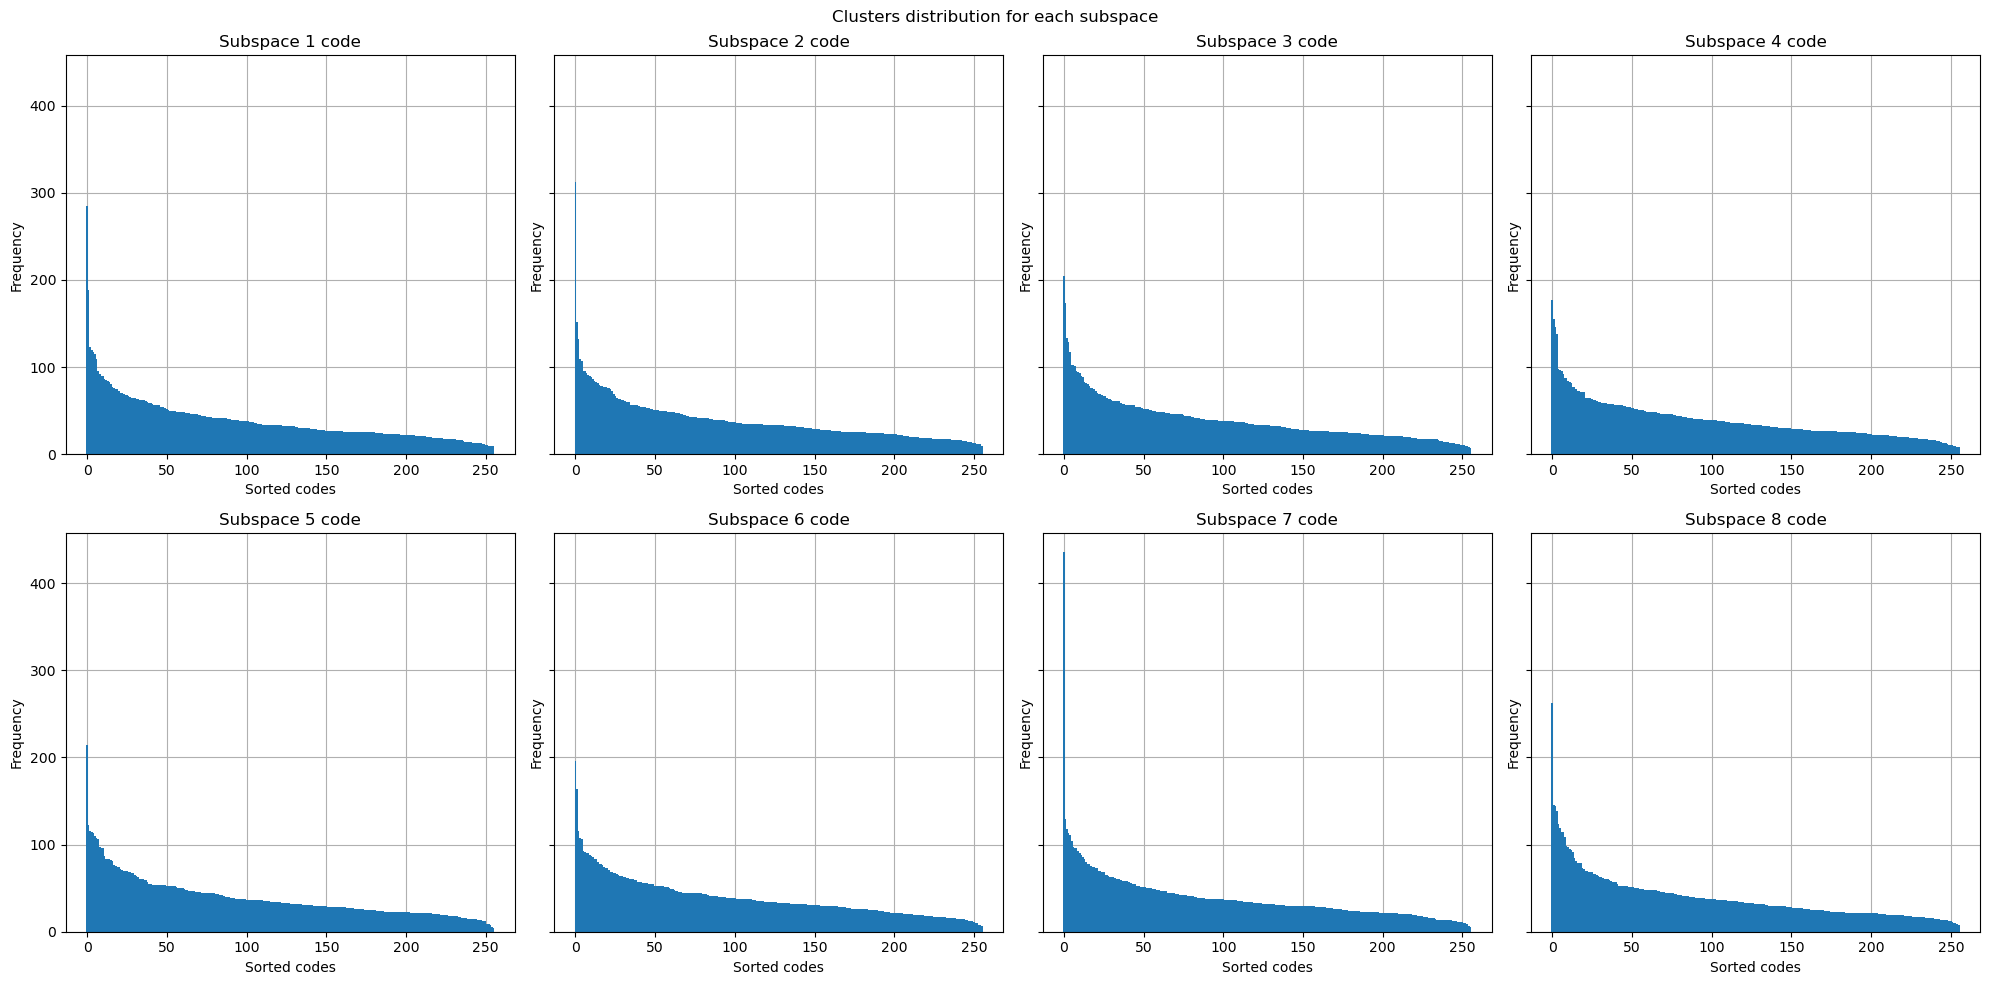

In [10]:
fig, axs = plt.subplots(2, 4, figsize=(20, 10), sharey=True)
id = 0
for m in range(pq.M):
    hist, bins = np.histogram(pq.pqcode[:, m], bins=range(pq.K+1))
    hist = sorted(hist, reverse=True)
    axs[int(id/4)][id%4].bar(bins[:-1], hist, width=1)
    axs[int(id/4)][id%4].set_title(f"Subspace {m+1} code")
    axs[int(id/4)][id%4].set_xlabel("Sorted codes")
    axs[int(id/4)][id%4].set_ylabel("Frequency")
    axs[int(id/4)][id%4].grid()
    axs[int(id/4)][id%4].set_axisbelow(True)
    id += 1

plt.suptitle("Clusters distribution for each subspace")
plt.tight_layout()
plt.show()

In [11]:
es = ExactSearch(search_data)
exact_dists, exact_ranking = es.search(sample_query)
# check if computed exact ranking is equal to ground truth
np.all(gt[0][:100]==exact_ranking[:100])

True

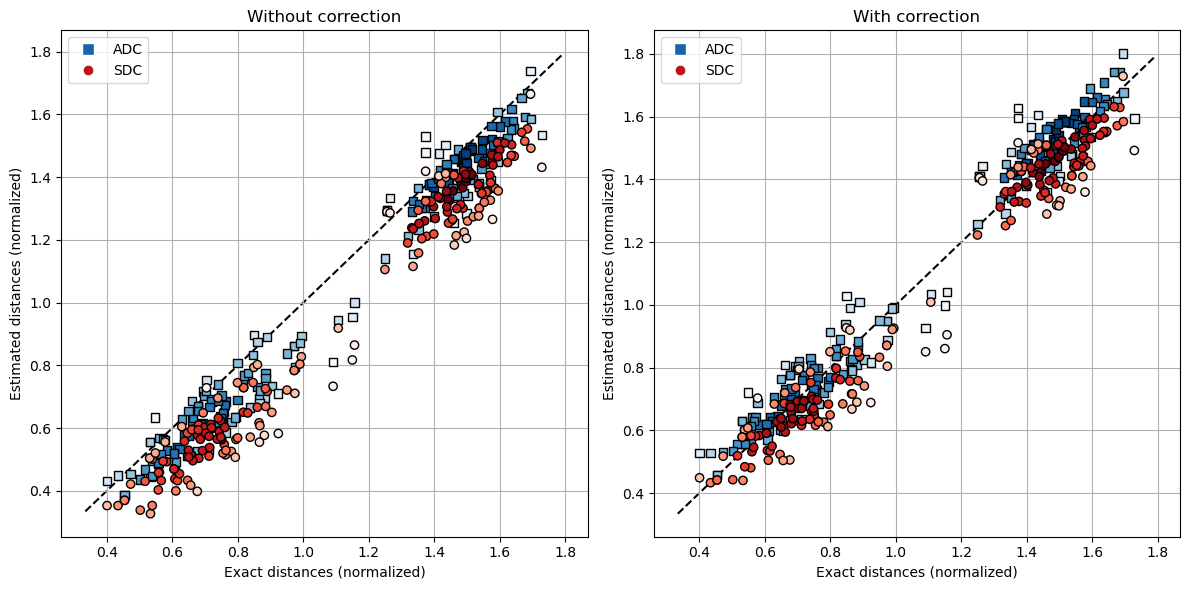

In [12]:
def plot_exact_vs_estimated(axs, exact_dists, asym_pq_dists, sym_pq_dists, query):
    query_snorm = np.sum(np.square(query))
    exact_dists = exact_dists / query_snorm
    asym_pq_dists = asym_pq_dists / query_snorm
    sym_pq_dists = sym_pq_dists / query_snorm
    
    xy_asym = np.vstack([exact_dists, asym_pq_dists])
    kernel_asym = gaussian_kde(xy_asym)(xy_asym)
    axs.scatter(
        exact_dists,
        asym_pq_dists,
        c=kernel_asym,
        cmap="Blues", edgecolor='black', label="ADC",
        zorder=2, marker='s')

    xy_sym = np.vstack([exact_dists, sym_pq_dists])
    kernel_sym = gaussian_kde(xy_sym)(xy_sym)
    axs.scatter(
        exact_dists,
        sym_pq_dists,
        c=kernel_sym,
        cmap="Reds", edgecolor='black', label="SDC",
        zorder=2, marker='o')

    axs.set_xlabel("Exact distances (normalized)")
    axs.set_ylabel("Estimated distances (normalized)")
    xpoints = axs.get_xlim()
    axs.plot(xpoints, xpoints, linestyle='--', color='black', zorder=1)
    axs.grid(zorder=0)
    legend_elements = [
        Line2D([0], [0], marker='s', color='w', label='ADC', markersize=8,
            markerfacecolor=matplotlib.colormaps['Blues'](0.8)),
        Line2D([0], [0], marker='o', color='w', label='SDC', markersize=8,
            markerfacecolor=matplotlib.colormaps['Reds'](0.8))
    ] # TODO: white border is missing
    axs.legend(handles=legend_elements);


asym_pq_dists, asym_ranking = pq.search(sample_query, subset=None, asym=True, correct=False)
asym_pq_corr_dists, asym_corr_ranking = pq.search(sample_query, subset=None, asym=True, correct=True)
sym_pq_dists, sym_ranking = pq.search(sample_query, subset=None, asym=False, correct=False)
sym_pq_corr_dists, sym_corr_ranking = pq.search(sample_query, subset=None, asym=False, correct=True)

SAMPLE_SIZE = 200
sample = np.random.randint(0, 1000, SAMPLE_SIZE)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
plot_exact_vs_estimated(axs[0], exact_dists[sample], asym_pq_dists[sample], sym_pq_dists[sample], sample_query)
axs[0].set_title("Without correction")
plot_exact_vs_estimated(axs[1], exact_dists[sample], asym_pq_corr_dists[sample], sym_pq_corr_dists[sample], sample_query)
axs[1].set_title("With correction");
plt.tight_layout()

In [13]:
asym_diffs = np.zeros((search_data.shape[0]*queries.shape[0]))
asym_diffs_corr = np.zeros((search_data.shape[0]*queries.shape[0]))
sym_diffs = np.zeros((search_data.shape[0]*queries.shape[0]))
sym_diffs_corr = np.zeros((search_data.shape[0]*queries.shape[0]))

exact_ranks = np.empty((len(queries), search_data.shape[0]))
mean_es_time = 0

for i, query in enumerate(queries):
    asym_d_est, asym_rank = pq.search(query, subset=None, asym=True, correct=False)
    asym_d_est_corr, asym_corr_rank = pq.search(query, subset=None, asym=True, correct=True)
    sym_d_est, sym_rank = pq.search(query, subset=None, asym=False, correct=False)
    sym_d_est_corr, sym_corr_rank = pq.search(query, subset=None, asym=False, correct=True)
    query_norm = np.sum(np.square(query))

    start_search_time = time.time()
    d, rank = es.search(query)
    mean_es_time += time.time() - start_search_time
    exact_ranks[i] = rank

    asym_diffs[i*search_data.shape[0]:(i+1)*search_data.shape[0]] = (asym_d_est-d) / query_norm
    asym_diffs_corr[i*search_data.shape[0]:(i+1)*search_data.shape[0]] = (asym_d_est_corr-d) / query_norm
    sym_diffs[i*search_data.shape[0]:(i+1)*search_data.shape[0]] = (sym_d_est-d) / query_norm
    sym_diffs_corr[i*search_data.shape[0]:(i+1)*search_data.shape[0]] = (sym_d_est_corr-d) / query_norm

mean_es_time /= len(queries)

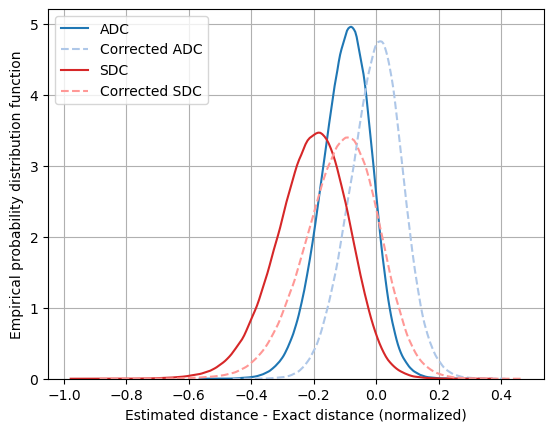

In [14]:
sns.kdeplot(asym_diffs, label="ADC", color=matplotlib.colormaps["tab20"](0))
sns.kdeplot(asym_diffs_corr, label="Corrected ADC", color=matplotlib.colormaps["tab20"](1), linestyle='dashed')
sns.kdeplot(sym_diffs, label="SDC", color=matplotlib.colormaps["tab20"](6))
sns.kdeplot(sym_diffs_corr, label="Corrected SDC", color=matplotlib.colormaps["tab20"](7), linestyle='dashed')
plt.xlabel("Estimated distance - Exact distance (normalized)")
plt.ylabel("Empirical probability distribution function")
plt.legend();
plt.grid()

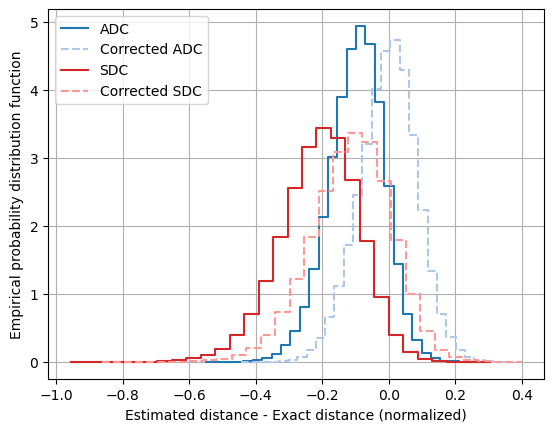

In [15]:
bins = 30

hist_asym, bin_edges_asym = np.histogram(asym_diffs, bins=bins, density=True)
plt.step(bin_edges_asym[:-1], hist_asym, where='post', label="ADC", color=matplotlib.colormaps["tab20"](0))

hist_asym_corr, bin_edges_asym_corr = np.histogram(asym_diffs_corr, bins=bins, density=True)
plt.step(bin_edges_asym_corr[:-1], hist_asym_corr, where='post', label="Corrected ADC", color=matplotlib.colormaps["tab20"](1), linestyle='dashed')

hist_sym, bin_edges_sym = np.histogram(sym_diffs, bins=bins, density=True)
plt.step(bin_edges_sym[:-1], hist_sym, where='post', label="SDC", color=matplotlib.colormaps["tab20"](6))

hist_sym_corr, bin_edges_sym_corr = np.histogram(sym_diffs_corr, bins=bins, density=True)
plt.step(bin_edges_sym_corr[:-1], hist_sym_corr, where='post', label="Corrected SDC", color=matplotlib.colormaps["tab20"](7), linestyle='dashed')

plt.xlabel("Estimated distance - Exact distance (normalized)")
plt.ylabel("Empirical probability distribution function")
plt.legend()
plt.grid()

In [16]:
asym_diff_var = np.var(asym_diffs)
asym_corr_diff_var = np.var(asym_diffs_corr)
sym_diff_var = np.var(sym_diffs)
sym_corr_diff_var = np.var(sym_diffs_corr)
pd.DataFrame({
    "ADC": [asym_diff_var],
    "Corrected ADC": [asym_corr_diff_var],
    "SDC": [sym_diff_var],
    "Corrected SDC": [sym_corr_diff_var],
    }, index=["Variance of error"])

,ADC,Corrected ADC,SDC,Corrected SDC
Variance of error,0.006804,0.007472,0.013667,0.014331


In [17]:
def compute_recall(index, R, queries, exact_ranks, w=4): # TODO: passa ranking
    asym_recall = np.full((len(queries), len(R)), np.nan)
    nearest_asym_recall = np.full((len(queries), len(R)), np.nan)
    asym_corr_recall = np.full((len(queries), len(R)), np.nan)  
    nearest_asym_corr_recall = np.full((len(queries), len(R)), np.nan)
    sym_recall = np.full((len(queries), len(R)), np.nan)
    nearest_sym_recall = np.full((len(queries), len(R)), np.nan)
    sym_corr_recall = np.full((len(queries), len(R)), np.nan)
    nearest_sym_corr_recall = np.full((len(queries), len(R)), np.nan)

    for i, query in enumerate(queries):
        if type(index) == PQ:
            _, asym_rank = index.search(query, subset=None, asym=True, correct=False)
            _, asym_corr_rank = index.search(query, subset=None, asym=True, correct=True)
            _, sym_rank = index.search(query, subset=None, asym=False, correct=False)
            _, sym_corr_rank = index.search(query, subset=None, asym=False, correct=True)
        else:
            _, asym_rank = index.search(query, w=w, asym=True, correct=False)
            _, asym_corr_rank = index.search(query, w=w, asym=True, correct=True)
            _, sym_rank = index.search(query, w=w, asym=False, correct=False)
            _, sym_corr_rank = index.search(query, w=w, asym=False, correct=True)

        for j, r in enumerate(R):
            if r <= len(asym_rank):
                asym_recall[i][j] = recall_at_r(asym_rank, exact_ranks[i], r)
                nearest_asym_recall[i][j] = exact_ranks[i][0] in asym_rank[:r]
            if r <= len(asym_corr_rank):
                asym_corr_recall[i][j] = recall_at_r(asym_corr_rank, exact_ranks[i], r)
                nearest_asym_corr_recall[i][j] = exact_ranks[i][0] in asym_corr_rank[:r]
            if r <= len(sym_rank):
                sym_recall[i][j] = recall_at_r(sym_rank, exact_ranks[i], r)
                nearest_sym_recall[i][j] = exact_ranks[i][0] in sym_rank[:r]
            if r <= len(sym_corr_rank):
                sym_corr_recall[i][j] = recall_at_r(sym_corr_rank, exact_ranks[i], r)
                nearest_sym_corr_recall[i][j] = exact_ranks[i][0] in sym_corr_rank[:r]

    with warnings.catch_warnings(record=True) as w:
        asym_recall_mean = np.nanmean(asym_recall, axis=0)
        nearest_asym_recall_mean = np.nanmean(nearest_asym_recall, axis=0)
        asym_corr_recall_mean = np.nanmean(asym_corr_recall, axis=0)
        nearest_asym_corr_recall_mean = np.nanmean(nearest_asym_corr_recall, axis=0)
        sym_recall_mean = np.nanmean(sym_recall, axis=0)
        nearest_sym_recall_mean = np.nanmean(nearest_sym_recall, axis=0)
        sym_corr_recall_mean = np.nanmean(sym_corr_recall, axis=0)
        nearest_sym_corr_recall_mean = np.nanmean(nearest_sym_corr_recall, axis=0)
        if w:
            for warning in w:
                if "Mean of empty slice" not in str(warning.message):
                    warnings.warn(warning.message, warning.category)

    results = {
        "asym_recall_mean": asym_recall_mean,
        "nearest_asym_recall_mean": nearest_asym_recall_mean,
        "asym_corr_recall_mean": asym_corr_recall_mean,
        "nearest_asym_corr_recall_mean": nearest_asym_corr_recall_mean,
        "sym_recall_mean": sym_recall_mean,
        "nearest_sym_recall_mean": nearest_sym_recall_mean,
        "sym_corr_recall_mean": sym_corr_recall_mean,
        "nearest_sym_corr_recall_mean": nearest_sym_corr_recall_mean,
        "inertia": index.inertia
    }

    return results

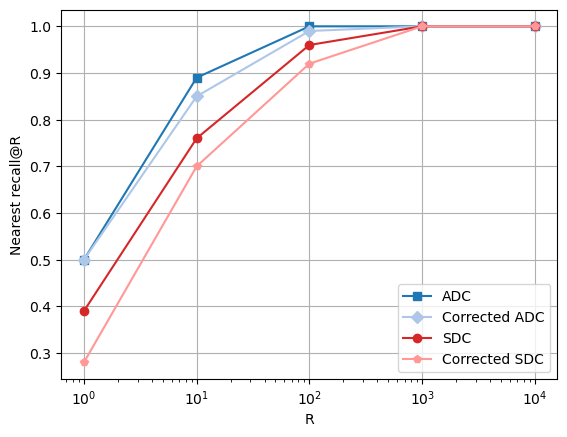

In [18]:
R = [1, 10, 100, 1000, 10000]
if DATASET == "sift":
    R += [100000, 1000000]

results_pq = compute_recall(pq, R, queries, exact_ranks)

plt.plot(R, results_pq["nearest_asym_recall_mean"], '-s', label="ADC", color=matplotlib.colormaps["tab20"](0))
plt.plot(R, results_pq["nearest_asym_corr_recall_mean"], '-D', label="Corrected ADC", color=matplotlib.colormaps["tab20"](1))
plt.plot(R, results_pq["nearest_sym_recall_mean"], '-o', label="SDC", color=matplotlib.colormaps["tab20"](6))
plt.plot(R, results_pq["nearest_sym_corr_recall_mean"], '-p', label="Corrected SDC", color=matplotlib.colormaps["tab20"](7))
plt.xscale('log')
plt.xlabel('R')
plt.ylabel('Nearest recall@R')
plt.legend()
plt.grid()

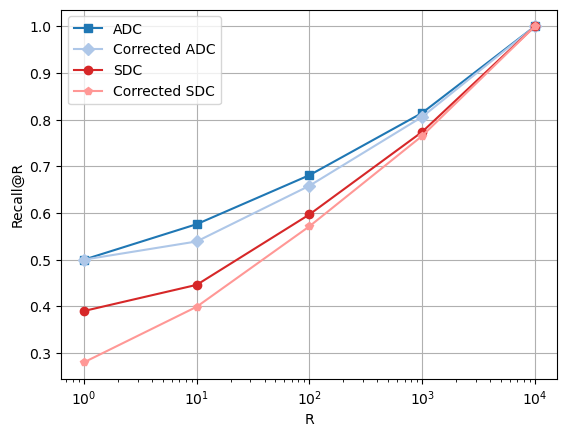

In [19]:
plt.plot(R, results_pq["asym_recall_mean"], '-s', label="ADC", color=matplotlib.colormaps["tab20"](0))
plt.plot(R, results_pq["asym_corr_recall_mean"], '-D', label="Corrected ADC", color=matplotlib.colormaps["tab20"](1))
plt.plot(R, results_pq["sym_recall_mean"], '-o', label="SDC", color=matplotlib.colormaps["tab20"](6))
plt.plot(R, results_pq["sym_corr_recall_mean"], '-p', label="Corrected SDC", color=matplotlib.colormaps["tab20"](7))
plt.xscale('log')
plt.xlabel('R')
plt.ylabel('Recall@R')
plt.legend()
plt.grid()

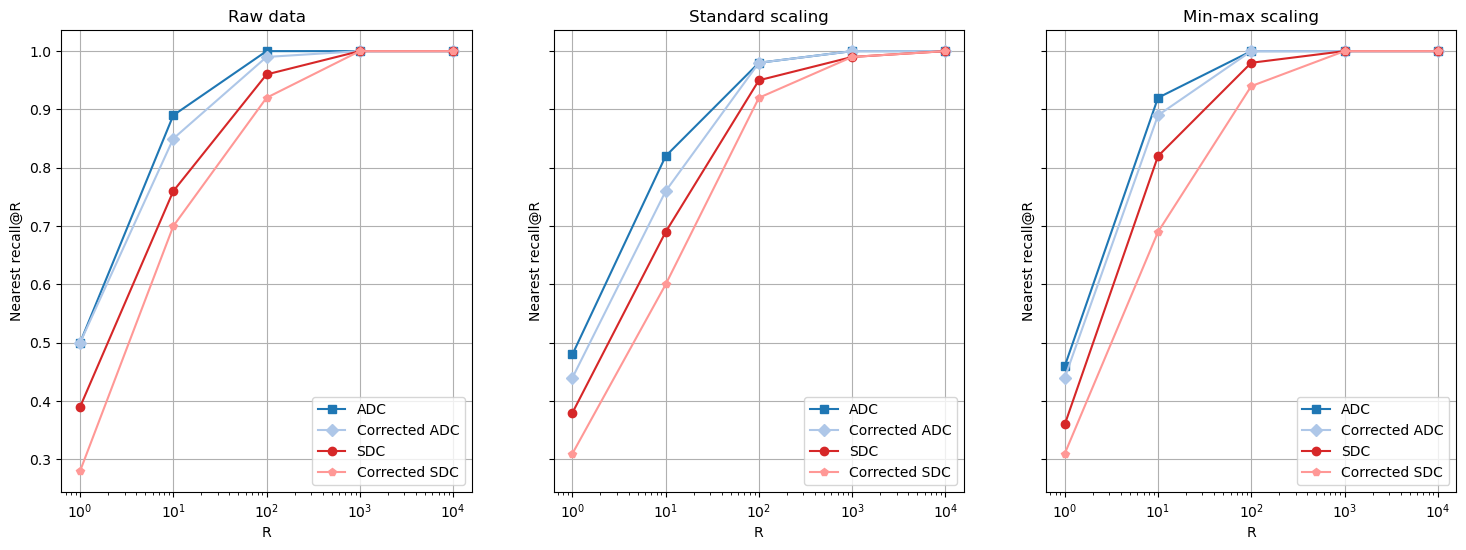

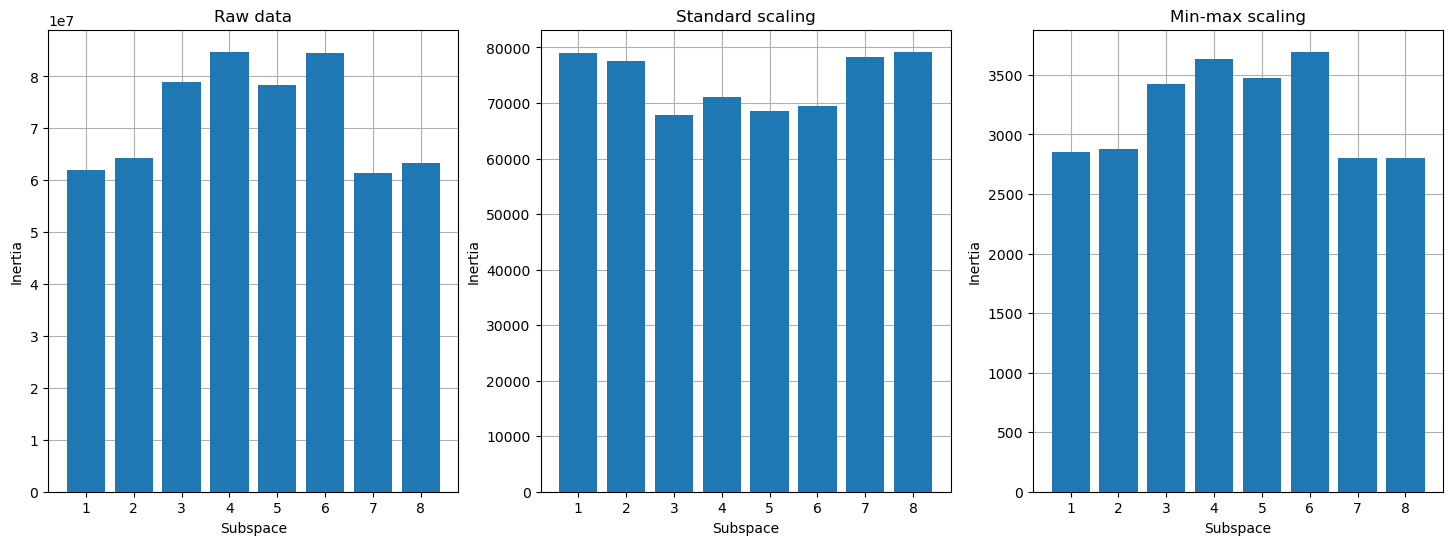

In [20]:
std_scaler = StandardScaler()
# tr_data_std = std_scaler.fit_transform(tr_data)
# search_data_std = std_scaler.transform(search_data)
# queries_std = std_scaler.transform(queries)
search_data_std = std_scaler.fit_transform(search_data)
tr_data_std = std_scaler.transform(tr_data)
queries_std = std_scaler.transform(queries)

minmax_scaler = MinMaxScaler()
# tr_data_minmax = minmax_scaler.fit_transform(tr_data)
# search_data_minmax = minmax_scaler.transform(search_data)
# queries_minmax = minmax_scaler.transform(queries)
search_data_minmax = minmax_scaler.fit_transform(search_data)
tr_data_minmax = minmax_scaler.transform(tr_data)
queries_minmax = minmax_scaler.transform(queries)

pq_std = PQ(M=M, K=K, seed=RANDOM_SEED)
pq_std.train(tr_data_std, add=False)
pq_std.add(search_data_std, compute_distortions=True)
results_pq_std = compute_recall(pq_std, R, queries_std, exact_ranks)

pq_minmax = PQ(M=M, K=K, seed=RANDOM_SEED)
pq_minmax.train(tr_data_minmax, add=False)
pq_minmax.add(search_data_minmax, compute_distortions=True)
results_pq_minmax = compute_recall(pq_minmax, R, queries_minmax, exact_ranks)

scaling_methods = [
    ("Raw data", results_pq),
    ("Standard scaling", results_pq_std),
    ("Min-max scaling", results_pq_minmax)
]

fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

for ax, (title, data) in zip(axs, scaling_methods):
    ax.plot(R, data["nearest_asym_recall_mean"], '-s', label="ADC", color=matplotlib.colormaps["tab20"](0))
    ax.plot(R, data["nearest_asym_corr_recall_mean"], '-D', label="Corrected ADC", color=matplotlib.colormaps["tab20"](1))
    ax.plot(R, data["nearest_sym_recall_mean"], '-o', label="SDC", color=matplotlib.colormaps["tab20"](6))
    ax.plot(R, data["nearest_sym_corr_recall_mean"], '-p', label="Corrected SDC", color=matplotlib.colormaps["tab20"](7))
    ax.set_xscale('log')
    ax.set_xlabel('R')
    ax.set_ylabel('Nearest recall@R')
    ax.set_title(title)
    ax.legend()
    ax.grid()
plt.show()

fig, axs = plt.subplots(1, 3, figsize=(18, 6))
for ax, (title, results) in zip(axs, scaling_methods):
    ax.bar(range(1, results["inertia"].shape[0]+1), results["inertia"], zorder=3)
    ax.set_xlabel('Subspace')
    ax.set_ylabel('Inertia')
    ax.set_title(title)
    ax.grid(zorder=0)
plt.show()

In [21]:
Ms = [1, 2, 4, 8, 16]
Ks = [16, 64, 256, 1024]

training_results = []
search_results = []

for m in Ms:
    for r in Ks:
        print(f"Training PQ with M={m}, K={r}...")
        
        pq = PQ(M=m, K=r, seed=RANDOM_SEED)
        start_training = time.time()
        pq.train(tr_data)
        training_time = time.time() - start_training
        start_adding = time.time()
        pq.add(search_data)
        adding_time = time.time() - start_adding
        
        decompressed_search = pq.decompress(pq.pqcode) 
        search_NMSE = NMSE(search_data, decompressed_search)
        compressed_tr = pq.compress(tr_data)
        decompressed_tr = pq.decompress(compressed_tr)
        tr_NMSE = NMSE(tr_data, decompressed_tr)

        code_length = np.log2(r) * m
        curr_training_res = {"M": m, "K": r, "Code length [bits]": code_length,
                  "Training time [s]": training_time, "Adding time [s]": adding_time,
                  "TR NMSE": tr_NMSE,
                  "SEARCH NMSE": search_NMSE}
        training_results.append(curr_training_res)
        
        for asym in [True, False]:
            mean_search_time = 0
            recall_tr = 0
            for i, query in enumerate(queries):
                start_search = time.time()
                _, ranking = pq.search(query, subset=None, asym=asym, correct=False)
                mean_search_time += (time.time() - start_search)
                if exact_ranks[i][0] in ranking[:100]:
                    recall_tr += 1
            mean_search_time /= len(queries)
            recall_tr /= len(queries)
            
            curr_search_res = {"M": m, "K": r, "Code length [bits]": code_length,
                          "Asymmetric Distance": asym,
                          "Mean search time [ms]": mean_search_time*1000,
                          "Recall@100": recall_tr}
            search_results.append(curr_search_res)

training_results = pd.DataFrame(training_results)
search_results = pd.DataFrame(search_results)

Training PQ with M=1, K=16...
Training PQ with M=1, K=64...
Training PQ with M=1, K=256...
Training PQ with M=1, K=1024...
Training PQ with M=2, K=16...
Training PQ with M=2, K=64...
Training PQ with M=2, K=256...
Training PQ with M=2, K=1024...
Training PQ with M=4, K=16...
Training PQ with M=4, K=64...
Training PQ with M=4, K=256...
Training PQ with M=4, K=1024...
Training PQ with M=8, K=16...
Training PQ with M=8, K=64...
Training PQ with M=8, K=256...
Training PQ with M=8, K=1024...
Training PQ with M=16, K=16...
Training PQ with M=16, K=64...
Training PQ with M=16, K=256...
Training PQ with M=16, K=1024...


In [22]:
training_results

,M,K,Code length [bits],Training time [s],Adding time [s],TR NMSE,SEARCH NMSE
0,1,16,4.0,0.431949,0.003454,0.295403,0.295698
1,1,64,6.0,1.083074,0.005571,0.254209,0.257719
2,1,256,8.0,2.894442,0.009190,0.220694,0.229798
3,1,1024,10.0,8.902773,0.045735,0.186407,0.211102
4,2,16,8.0,1.024450,0.006817,0.273406,0.276041
5,2,64,12.0,1.791719,0.007752,0.226354,0.229256
6,2,256,16.0,3.801487,0.026212,0.187148,0.195938
7,2,1024,20.0,11.003225,0.057771,0.150360,0.172441
8,4,16,16.0,1.960122,0.011333,0.247365,0.250464
9,4,64,24.0,2.361530,0.043065,0.191399,0.194884


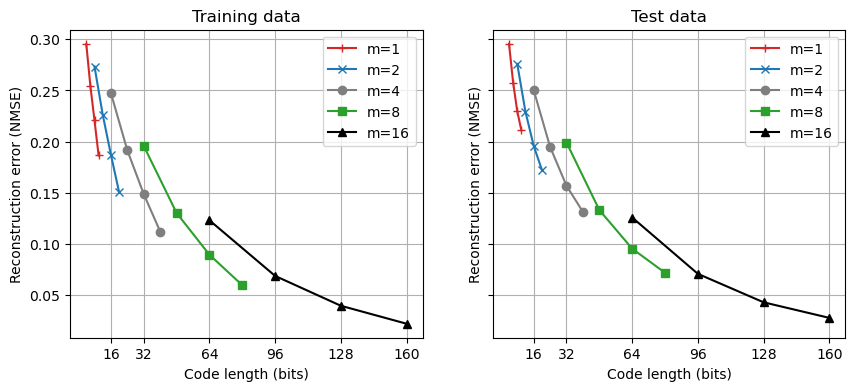

In [23]:
colors = ['tab:red', 'tab:blue', 'tab:gray', 'tab:green', 'black']
markers = ['+', 'x', 'o', 's', '^']

fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
for i, m in enumerate(Ms):
    res = training_results[training_results["M"]==m]
    axs[0].plot(res["Code length [bits]"], res["TR NMSE"], marker=markers[i], color=colors[i], label=f"m={m}")
    axs[1].plot(res["Code length [bits]"], res["SEARCH NMSE"], marker=markers[i], color=colors[i], label=f"m={m}")

axs[0].set_xticks([16, 32, 64, 96, 128, 160])
axs[0].set_xlabel("Code length (bits)")
axs[0].set_ylabel("Reconstruction error (NMSE)")
axs[0].set_title("Training data")
axs[0].legend()
axs[0].grid()
axs[1].set_xticks([16, 32, 64, 96, 128, 160])
axs[1].set_xlabel("Code length (bits)")
axs[1].set_ylabel("Reconstruction error (NMSE)")
axs[1].set_title("Test data")
axs[1].legend()
axs[1].grid()

In [24]:
print(f"Mean Exact Search time: {mean_es_time*1000} [ms]")
search_results

Mean Exact Search time: 1.4944744110107422 [ms]


,M,K,Code length [bits],Asymmetric Distance,Mean search time [ms],Recall@100
0,1,16,4.0,True,0.582716,0.19
1,1,16,4.0,False,0.461247,0.14
2,1,64,6.0,True,0.617409,0.38
3,1,64,6.0,False,0.651417,0.31
4,1,256,8.0,True,0.682855,0.69
5,1,256,8.0,False,0.762386,0.56
6,1,1024,10.0,True,0.859022,0.83
7,1,1024,10.0,False,1.003242,0.65
8,2,16,8.0,True,1.001332,0.42
9,2,16,8.0,False,0.877795,0.39


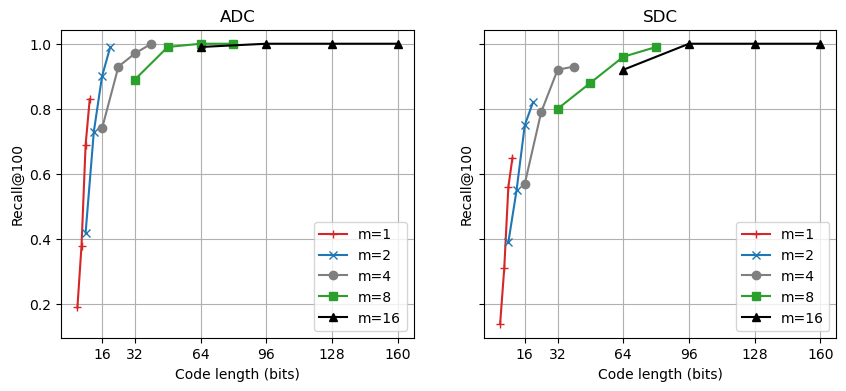

In [25]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
for i, m in enumerate(Ms):
    asym_res = search_results[(search_results["M"]==m) &(search_results["Asymmetric Distance"]==True)]
    axs[0].plot(asym_res["Code length [bits]"], asym_res["Recall@100"], marker=markers[i], color=colors[i], label=f"m={m}")
    sym_res = search_results[(search_results["M"]==m) &(search_results["Asymmetric Distance"]==False)]
    axs[1].plot(sym_res["Code length [bits]"], sym_res["Recall@100"], marker=markers[i], color=colors[i], label=f"m={m}")

axs[0].set_xticks([16, 32, 64, 96, 128, 160])
axs[0].set_xlabel("Code length (bits)")
axs[0].set_ylabel("Recall@100")
axs[0].set_title("ADC")
axs[0].legend()
axs[0].grid()
axs[1].set_xticks([16, 32, 64, 96, 128, 160])
axs[1].set_xlabel("Code length (bits)")
axs[1].set_ylabel("Recall@100")
axs[1].set_title("SDC")
axs[1].legend()
axs[1].grid()

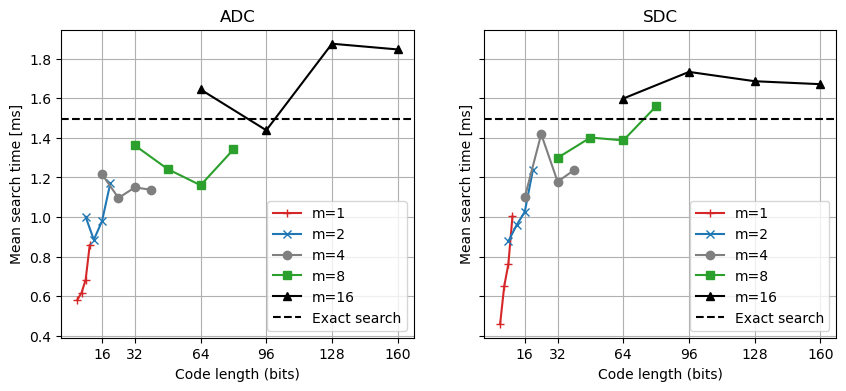

In [26]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
for i, m in enumerate(Ms):
    asym_res = search_results[(search_results["M"]==m) &(search_results["Asymmetric Distance"]==True)]
    axs[0].plot(asym_res["Code length [bits]"], asym_res["Mean search time [ms]"], marker=markers[i], color=colors[i], label=f"m={m}")
    sym_res = search_results[(search_results["M"]==m) &(search_results["Asymmetric Distance"]==False)]
    axs[1].plot(sym_res["Code length [bits]"], sym_res["Mean search time [ms]"], marker=markers[i], color=colors[i], label=f"m={m}")

axs[0].axhline(mean_es_time*1000, 0, 32, color='black', linestyle='--', label="Exact search")
axs[1].axhline(mean_es_time*1000, 0, 32, color='black', linestyle='--', label="Exact search")

axs[0].set_xticks([16, 32, 64, 96, 128, 160])
axs[0].set_xlabel("Code length (bits)")
axs[0].set_ylabel("Mean search time [ms]")
axs[0].set_title("ADC")
axs[0].legend()
axs[0].grid()
axs[1].set_xticks([16, 32, 64, 96, 128, 160])
axs[1].set_xlabel("Code length (bits)")
axs[1].set_ylabel("Mean search time [ms]")
axs[1].set_title("SDC")
axs[1].legend()
axs[1].grid()

In [27]:
# from sklearn.cluster import SpectralCoclustering
# clustering = SpectralCoclustering(n_clusters=M*K, random_state=RANDOM_SEED).fit(tr_data)
# np.unique(clustering.column_labels_).shape[0]

In [28]:
# np.sort(clustering.column_labels_)

In [29]:
# clustering = SpectralCoclustering(n_clusters=M, random_state=RANDOM_SEED).fit(tr_data)
# clustering.column_labels_ 

KMeans on subspace 1 converged in 66 iterations with an inertia of 49132196.0.
KMeans on subspace 2 converged in 59 iterations with an inertia of 101294944.0.
KMeans on subspace 3 converged in 80 iterations with an inertia of 74293040.0.
KMeans on subspace 4 converged in 60 iterations with an inertia of 422719392.0.
KMeans on subspace 5 converged in 55 iterations with an inertia of 20396712.0.
KMeans on subspace 6 converged in 59 iterations with an inertia of 8353994.0.
KMeans on subspace 7 converged in 52 iterations with an inertia of 29578320.0.
KMeans on subspace 8 converged in 64 iterations with an inertia of 98897832.0.


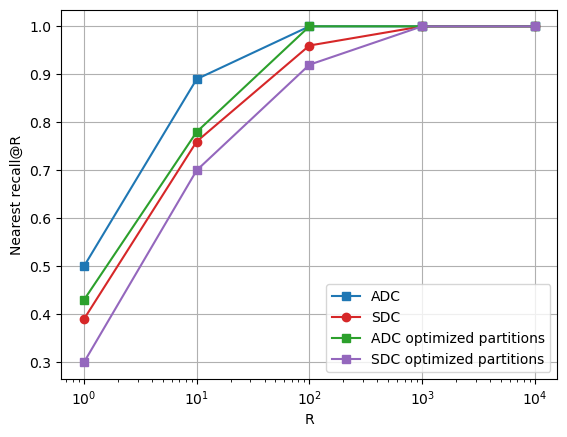

In [30]:
pq_opt_part = PQ(M=M, K=K, seed=RANDOM_SEED, optimize_partitions=True, )
pq_opt_part.train(tr_data, add=False, verbose=True)
pq_opt_part.add(search_data, compute_distortions=True)
results_pq_opt_part = compute_recall(pq_opt_part, R, queries, exact_ranks)

plt.plot(R, results_pq["nearest_asym_recall_mean"], '-s', label="ADC", color=matplotlib.colormaps["tab20"](0))
plt.plot(R, results_pq["nearest_sym_recall_mean"], '-o', label="SDC", color=matplotlib.colormaps["tab20"](6))
plt.plot(R, results_pq_opt_part["nearest_asym_recall_mean"], '-s', label="ADC optimized partitions", color=matplotlib.colormaps["tab20"](4))
plt.plot(R, results_pq_opt_part["nearest_sym_recall_mean"], '-s', label="SDC optimized partitions", color=matplotlib.colormaps["tab20"](8))
plt.xscale('log')
plt.xlabel('R')
plt.ylabel('Nearest recall@R')
plt.legend()
plt.grid()

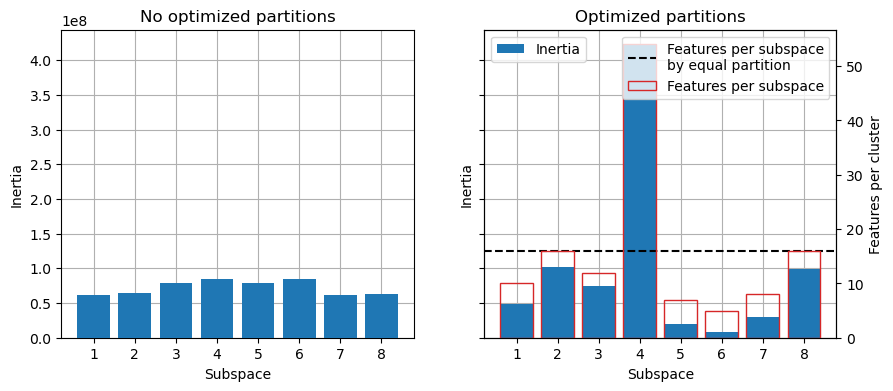

In [56]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

axs[0].bar(range(1, results_pq["inertia"].shape[0]+1), results_pq["inertia"], zorder=3)
axs[0].set_xlabel('Subspace')
axs[0].set_ylabel('Inertia')
axs[0].set_title('No optimized partitions')
axs[0].set_xticks(range(1, results_pq["inertia"].shape[0]+1))
axs[0].grid(zorder=0)

axs[1].bar(range(1, results_pq_opt_part["inertia"].shape[0]+1), results_pq_opt_part["inertia"], zorder=3, label='Inertia')
axs[1].set_xlabel('Subspace')
axs[1].set_ylabel('Inertia')
axs[1].set_title('Optimized partitions')
axs[1].set_xticks(range(1, results_pq_opt_part["inertia"].shape[0]+1))
axs[1].grid(zorder=0)
axs[1].legend(loc='upper left')

axs1 = axs[1].twinx()
axs1.bar(range(1, M+1), pq_opt_part.col_cluster_sizes, zorder=3, facecolor='none', edgecolor=matplotlib.colormaps["tab20"](6), label='Features per subspace')
axs1.axhline(int(tr_data.shape[1]/M), color='black', linestyle='--', label='Features per subspace\nby equal partition')
axs1.set_ylabel('Features per cluster');
axs1.legend(loc='upper right');

In [32]:
# display IVF implementation
# with open(file_path, 'r') as file:
#     lines = file.readlines()
# selected_lines = ''.join(lines[152:259])
# display(Code(data=selected_lines, language='python'))

In [21]:
W = 8
if DATASET == "siftsmall":
    KP = 128
else:
    KP = 1024

ivf = IVF(Kp=KP, M=M, K=K, seed=RANDOM_SEED)
start_training_ivf = time.time()
ivf.train(tr_data, add=False)
training_ivf = time.time() - start_training_ivf

start_adding_ivf = time.time()
ivf.add(search_data, compute_distortions=True)
adding_ivf = time.time() - start_adding_ivf

print(f"Training time (with avg dist computation): {training_ivf:.2f} s")
print(f"Adding time (with avg dist computation): {adding_ivf:.2f} s")

Training time (with avg dist computation): 6.17 s
Adding time (with avg dist computation): 0.21 s


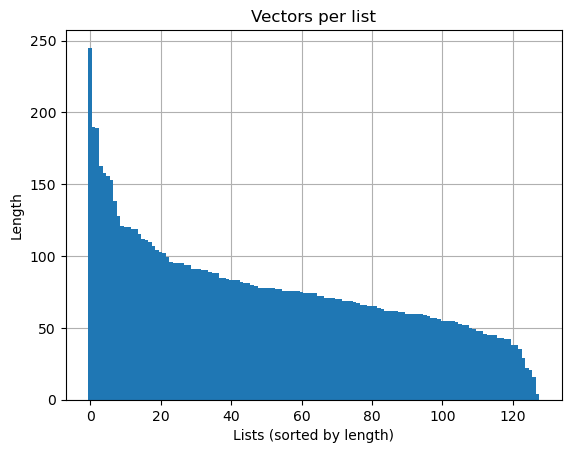

In [22]:
els_per_cluster = []
for i in range(ivf.Kp):
    els_per_cluster.append(len(ivf.ivf[i]))
fig, axs = plt.subplots(1)
axs.bar(range(ivf.Kp), sorted(els_per_cluster, reverse=True), width=1.0)
axs.set_xlabel("Lists (sorted by length)")
axs.set_ylabel("Length")
axs.set_title("Vectors per list")
axs.set_axisbelow(True)
axs.grid()

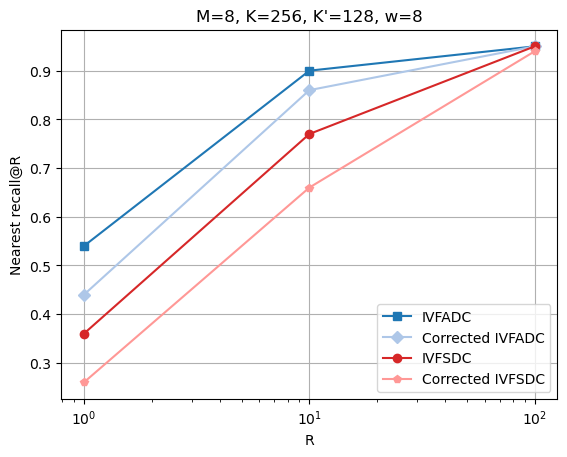

In [23]:
results_ivf = compute_recall(ivf, R, queries, exact_ranks, w=W)

plt.plot(R, results_ivf["nearest_asym_recall_mean"], '-s', label="IVFADC", color=matplotlib.colormaps["tab20"](0))
plt.plot(R, results_ivf["nearest_asym_corr_recall_mean"], '-D', label="Corrected IVFADC", color=matplotlib.colormaps["tab20"](1))
plt.plot(R, results_ivf["nearest_sym_recall_mean"], '-o', label="IVFSDC", color=matplotlib.colormaps["tab20"](6))
plt.plot(R, results_ivf["nearest_sym_corr_recall_mean"], '-p', label="Corrected IVFSDC", color=matplotlib.colormaps["tab20"](7))
plt.xscale('log')
plt.xlabel('R')
plt.ylabel('Nearest recall@R')
plt.title(f"M={M}, K={K}, K'={KP}, w={W}")
plt.legend()
plt.grid()

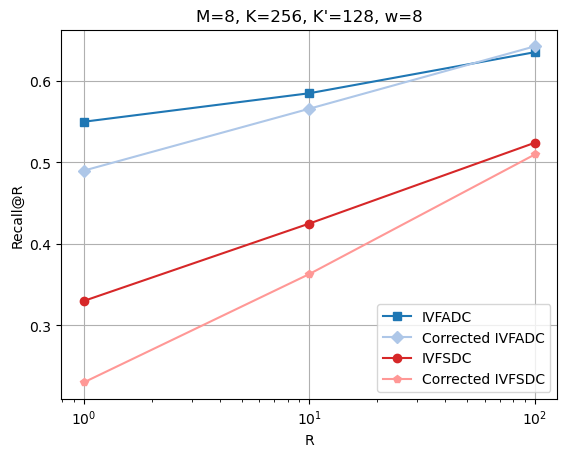

In [24]:
plt.plot(R, results_ivf["asym_recall_mean"], '-s', label="IVFADC", color=matplotlib.colormaps["tab20"](0))
plt.plot(R, results_ivf["asym_corr_recall_mean"], '-D', label="Corrected IVFADC", color=matplotlib.colormaps["tab20"](1))
plt.plot(R, results_ivf["sym_recall_mean"], '-o', label="IVFSDC", color=matplotlib.colormaps["tab20"](6))
plt.plot(R, results_ivf["sym_corr_recall_mean"], '-p', label="Corrected IVFSDC", color=matplotlib.colormaps["tab20"](7))
plt.xscale('log')
plt.xlabel('R')
plt.ylabel('Recall@R')
plt.title(f"M={M}, K={K}, K'={KP}, w={W}")
plt.legend()
plt.grid()

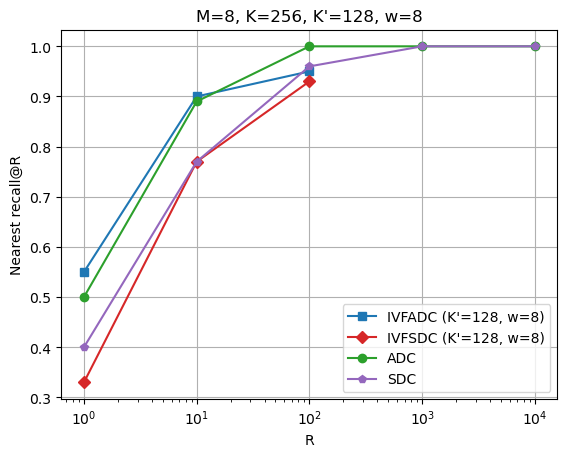

In [25]:
plt.plot(R, results_ivf["nearest_asym_recall_mean"], '-s', label=f"IVFADC (K'={KP}, w={W})", color=matplotlib.colormaps["tab20"](0))
plt.plot(R, results_ivf["nearest_sym_recall_mean"], '-D', label=f"IVFSDC (K'={KP}, w={W})", color=matplotlib.colormaps["tab20"](6))
plt.plot(R, results_pq["nearest_asym_recall_mean"], '-o', label="ADC", color=matplotlib.colormaps["tab20"](4))
plt.plot(R, results_pq["nearest_sym_recall_mean"], '-p', label="SDC", color=matplotlib.colormaps["tab20"](8))
plt.xscale('log')
plt.xlabel('R')
plt.ylabel('Nearest recall@R')
plt.title(f"M={M}, K={K}, K'={KP}, w={W}")
plt.legend()
plt.grid()

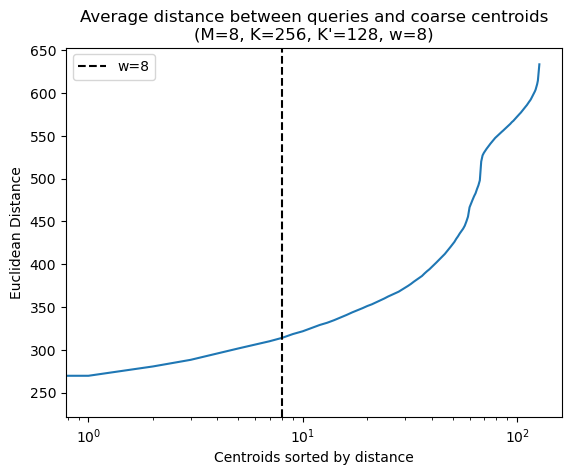

In [26]:
mean_dists2centroids = np.zeros(ivf.Kp)

for i, query in enumerate(queries):
    _, ivf_asym_rank = ivf.search(query, w=W, asym=True, correct=False)
    dist2centroids = cdist([query], ivf.centroids, 'euclidean')[0]
    sorteddist2centroids = np.sort(dist2centroids)
    mean_dists2centroids += sorteddist2centroids

mean_dists2centroids /= len(queries)

plt.plot(mean_dists2centroids)
plt.xlabel("Centroids sorted by distance")
plt.ylabel("Euclidean Distance")
plt.axvline(x=W, color='k', linestyle='--', label=f"w={W}")
plt.xscale('log')
plt.legend()
plt.title(f"Average distance between queries and coarse centroids\n(M={M}, K={K}, K'={KP}, w={W})");

------


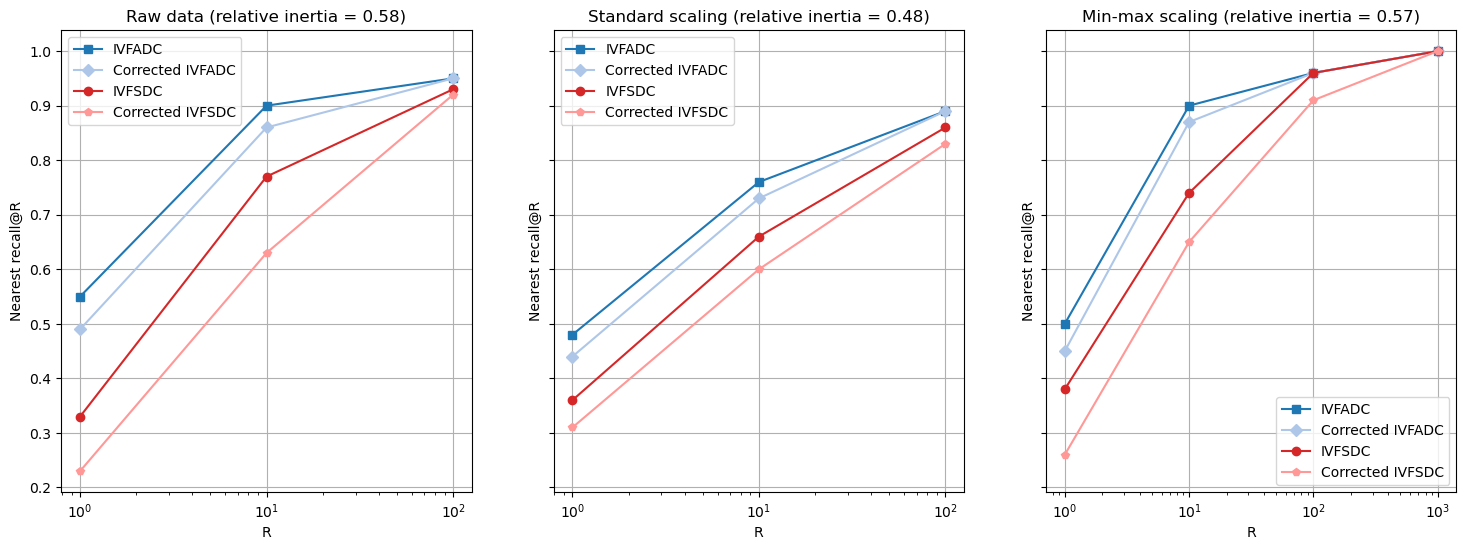

In [ ]:
ivf_std = IVF(Kp=KP, M=M, K=K, seed=RANDOM_SEED)
ivf_std.train(tr_data_std, add=False)
ivf_std.add(search_data_std, compute_distortions=True)
results_ivf_std = compute_recall(ivf_std, R, queries_std, exact_ranks, w=W)

ivf_minmax = IVF(Kp=KP, M=M, K=K, seed=RANDOM_SEED)
ivf_minmax.train(tr_data_minmax, add=False)
ivf_minmax.add(search_data_minmax, compute_distortions=True)
results_ivf_minmax = compute_recall(ivf_minmax, R, queries_minmax, exact_ranks, w=W)

def compute_overall_inertia(data):
    mean = np.mean(data, axis=0)
    return np.sum(np.square(data - mean))

overall_inertia = compute_overall_inertia(tr_data)
overall_inertia_std = compute_overall_inertia(tr_data_std)
overall_inertia_minmax = compute_overall_inertia(tr_data_minmax)

scaling_methods_ivf = [
    ("Raw data", results_ivf, overall_inertia),
    ("Standard scaling", results_ivf_std, overall_inertia_std),
    ("Min-max scaling", results_ivf_minmax, overall_inertia_minmax)
]

fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

for ax, (title, data, overall_inertia) in zip(axs, scaling_methods_ivf):
    ax.plot(R, data["nearest_asym_recall_mean"], '-s', label="IVFADC", color=matplotlib.colormaps["tab20"](0))
    ax.plot(R, data["nearest_asym_corr_recall_mean"], '-D', label="Corrected IVFADC", color=matplotlib.colormaps["tab20"](1))
    ax.plot(R, data["nearest_sym_recall_mean"], '-o', label="IVFSDC", color=matplotlib.colormaps["tab20"](6))
    ax.plot(R, data["nearest_sym_corr_recall_mean"], '-p', label="Corrected IVFSDC", color=matplotlib.colormaps["tab20"](7))
    ax.set_xscale('log')
    ax.set_xlabel('R')
    ax.set_ylabel('Nearest recall@R')
    ax.set_title(f"{title} (relative inertia = {1-(data['inertia'] / overall_inertia):.2f})")
    ax.legend()
    ax.grid()
plt.show()

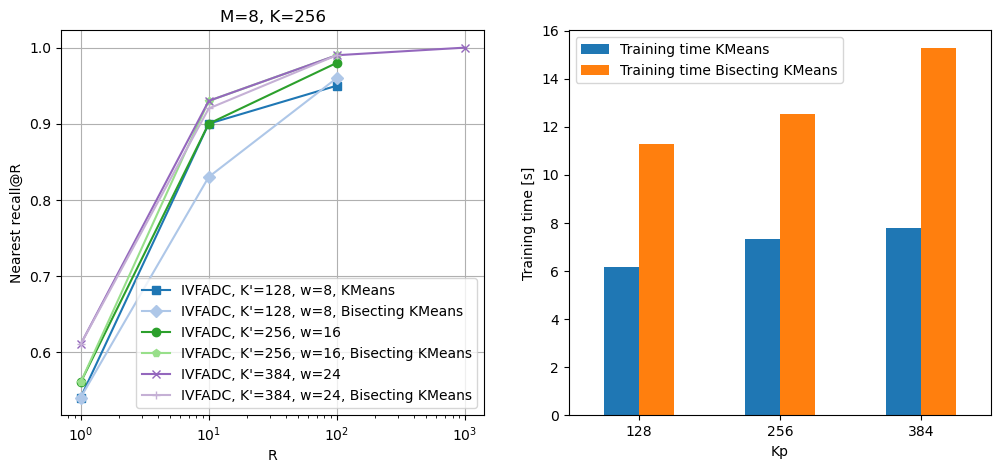

In [ ]:
def IVF_recall_time(M, K, KP, W, bisectingkmeans, tr_data, search_data, queries, exact_ranks, seed=RANDOM_SEED):
    ivf = IVF(Kp=KP, M=M, K=K, seed=seed, bisectingkmeans=bisectingkmeans)
    start_training_ivf = time.time()
    ivf.train(tr_data, add=False)
    training_ivf = time.time() - start_training_ivf
    ivf.add(search_data, compute_distortions=True)
    results_ivf = compute_recall(ivf, R, queries, exact_ranks, w=W)
    return results_ivf, training_ivf

results_ivf_bis, training_ivf_bis = IVF_recall_time(M, K, KP, W, True, tr_data, search_data, queries, exact_ranks, seed=RANDOM_SEED)
results_ivf_double, training_ivf_double = IVF_recall_time(M, K, KP*2, W*2, False, tr_data, search_data, queries, exact_ranks, seed=RANDOM_SEED)
results_ivf_bis_double, training_ivf_bis_double = IVF_recall_time(M, K, KP*2, W*2, True, tr_data, search_data, queries, exact_ranks, seed=RANDOM_SEED)
results_ivf_triple, training_ivf_triple = IVF_recall_time(M, K, KP*3, W*3, False, tr_data, search_data, queries, exact_ranks, seed=RANDOM_SEED)
results_ivf_bis_triple, training_ivf_bis_triple = IVF_recall_time(M, K, KP*3, W*3, True, tr_data, search_data, queries, exact_ranks, seed=RANDOM_SEED)

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].plot(R, results_ivf["nearest_asym_recall_mean"], '-s', label=f"IVFADC, K'={KP}, w={W}, KMeans", color=matplotlib.colormaps["tab20"](0))
axs[0].plot(R, results_ivf_bis["nearest_asym_recall_mean"], '-D', label=f"IVFADC, K'={KP}, w={W}, Bisecting KMeans", color=matplotlib.colormaps["tab20"](1))
axs[0].plot(R, results_ivf_double["nearest_asym_recall_mean"], '-o', label=f"IVFADC, K'={KP*2}, w={W*2}", color=matplotlib.colormaps["tab20"](4))
axs[0].plot(R, results_ivf_bis_double["nearest_asym_recall_mean"], '-p', label=f"IVFADC, K'={KP*2}, w={W*2}, Bisecting KMeans", color=matplotlib.colormaps["tab20"](5))
axs[0].plot(R, results_ivf_triple["nearest_asym_recall_mean"], '-x', label=f"IVFADC, K'={KP*3}, w={W*3}", color=matplotlib.colormaps["tab20"](8))
axs[0].plot(R, results_ivf_bis_triple["nearest_asym_recall_mean"], '-+', label=f"IVFADC, K'={KP*3}, w={W*3}, Bisecting KMeans", color=matplotlib.colormaps["tab20"](9))
axs[0].set_xscale('log')
axs[0].set_xlabel('R')
axs[0].set_ylabel('Nearest recall@R')
axs[0].set_title(f"M={M}, K={K}")
axs[0].legend()
axs[0].grid()

colors = [matplotlib.colormaps["tab20"](0), matplotlib.colormaps["tab20"](4), matplotlib.colormaps["tab20"](8)]
df = pd.DataFrame({
    "Kp": [KP, KP*2, KP*3],
    "Training time KMeans": [training_ivf, training_ivf_double, training_ivf_triple],
    "Training time Bisecting KMeans": [training_ivf_bis, training_ivf_bis_double, training_ivf_bis_triple]
    })
df.set_index('Kp', inplace=True)
df.plot.bar(rot=0, color=[matplotlib.colormaps["tab20"](0), matplotlib.colormaps["tab20"](2)], ax=axs[1])
axs[1].set_ylabel("Training time [s]");

In [40]:
K = 256
Ms = [1, 2, 4, 8, 16]
if DATASET == "siftsmall":
    Kps = [16, 128]
    ws = [1, 2, 8]
else:
    Kps = [1024, 8192]
    ws = [1, 8, 64]

ivf_training_results = []
ivf_search_results = []

for m in Ms:
    for Kp in Kps:
        print(f"Training PQ with M={m}, K'={Kp}...")
        
        ivf = IVF(Kp=Kp, M=m, K=K, seed=RANDOM_SEED)
        start_training = time.time()
        ivf.train(tr_data, add=False)
        training_time = time.time() - start_training
        start_adding = time.time()
        ivf.add(search_data)
        adding_time = time.time() - start_adding

        code_length = np.log2(K) * m
        curr_training_res = {"M": m, "K": K, "Kp": Kp,
                             "Code length [bits]": code_length,
                             "Training time [s]": training_time,
                             "Adding time [s]": adding_time}
        ivf_training_results.append(curr_training_res)
        
        for w in ws:
            if (Kp == Kps[0] and w == ws[-1]) or (Kp == Kps[-1] and w == ws[0]):
                continue
            mean_search_time = 0
            recall_tr = 0
            for i, query in enumerate(queries):
                start_search = time.time()
                _, ranking = ivf.search(query, w=w, asym=True, correct=False)
                mean_search_time += (time.time() - start_search)
                if exact_ranks[i][0] in ranking[:100]:
                    recall_tr += 1
            mean_search_time /= len(queries)
            recall_tr /= len(queries)
            
            curr_search_res = {"M": m, "K": K, "Kp": Kp, "w":w,
                               "Code length [bits]": code_length,
                               "Mean search time [ms]": mean_search_time*1000,
                               "Recall@100": recall_tr}
            ivf_search_results.append(curr_search_res)

ivf_training_results = pd.DataFrame(ivf_training_results)
ivf_search_results = pd.DataFrame(ivf_search_results)

Training PQ with M=1, K'=16...
Training PQ with M=1, K'=128...
Training PQ with M=2, K'=16...
Training PQ with M=2, K'=128...
Training PQ with M=4, K'=16...
Training PQ with M=4, K'=128...
Training PQ with M=8, K'=16...
Training PQ with M=8, K'=128...
Training PQ with M=16, K'=16...
Training PQ with M=16, K'=128...


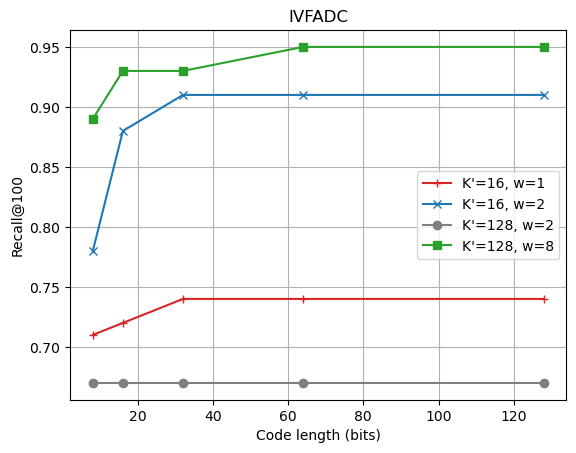

In [41]:
i = 0
for Kp in Kps:
    for w in ws:
        if (Kp == Kps[0] and w == ws[-1]) or (Kp == Kps[-1] and w == ws[0]):
                continue
        res = ivf_search_results[(ivf_search_results["Kp"]==Kp) & (ivf_search_results["w"]==w)]
        plt.plot(res["Code length [bits]"], res["Recall@100"], marker=markers[i], color=colors[i], label=f"K'={Kp}, w={w}")
        i += 1

plt.xlabel("Code length (bits)")
plt.ylabel("Recall@100")
plt.title("IVFADC")
plt.legend()
plt.grid()

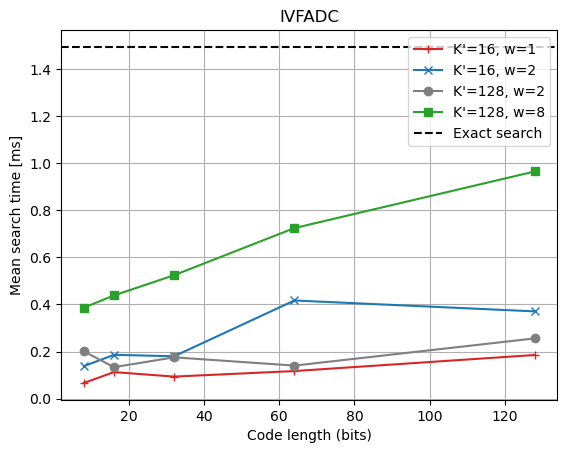

In [42]:
i = 0
for Kp in Kps:
    for w in ws:
        if (Kp == Kps[0] and w == ws[-1]) or (Kp == Kps[-1] and w == ws[0]):
            continue
        res = ivf_search_results[(ivf_search_results["Kp"]==Kp) & (ivf_search_results["w"]==w)]
        plt.plot(res["Code length [bits]"], res["Mean search time [ms]"], marker=markers[i], color=colors[i], label=f"K'={Kp}, w={w}")
        i += 1

plt.axhline(mean_es_time*1000, 0, 32, color='black', linestyle='--', label="Exact search")

plt.xlabel("Code length (bits)")
plt.ylabel("Mean search time [ms]")
plt.title("IVFADC")
plt.legend()
plt.grid()

In [43]:
ivf_search_results[(ivf_search_results["M"]==8)]

,M,K,Kp,w,Code length [bits],Mean search time [ms],Recall@100
12,8,256,16,1,64.0,0.117135,0.74
13,8,256,16,2,64.0,0.417054,0.91
14,8,256,128,2,64.0,0.140336,0.67
15,8,256,128,8,64.0,0.724666,0.95


In [44]:
search_results[(search_results["M"]==8) & (search_results["K"]==256)]

,M,K,Code length [bits],Asymmetric Distance,Mean search time [ms],Recall@100
28,8,256,64.0,True,1.160791,1.00
29,8,256,64.0,False,1.387305,0.96


<img src="./img/sift_img.png" alt="My Image" width="500"/>

For the m = 4 SIFT quantizer, this means that the 4×4 patch cells that make up the descriptor are grouped into 4 2 × 2 blocks. For the other two, it groups together dimensions that have have the same index modulo 8.

In [45]:
struct_perm = list(range(0, 16)) + list(range(32, 48)) + \
    list(range(16, 32)) + list(range(48, 64)) + \
    list(range(64, 80)) + list(range(96, 112)) + \
    list(range(80, 96)) + list(range(112, 128))
tr_data_struct_perm = tr_data[:, struct_perm]
queries_struct_perm = queries[:, struct_perm]
search_data_struct_perm = search_data[:, struct_perm]

pq_struct_perm = PQ(M=4, K=K, seed=RANDOM_SEED)
print("Training PQ with structured permutation on training data...")
pq_struct_perm.train(tr_data_struct_perm, add=False)
pq_struct_perm.add(search_data_struct_perm)

recall_struct_perm_tr = np.zeros(queries_struct_perm.shape[0])
for i, query in enumerate(queries_struct_perm):
    _, asym_struct_perm_rank = pq_struct_perm.search(query, subset=None, asym=True, correct=False)
    recall_struct_perm_tr[i] = exact_ranks[i][0] in asym_struct_perm_rank[:10]
recall_struct_perm_tr = np.mean(recall_struct_perm_tr)

pq = PQ(M=4, K=K, seed=RANDOM_SEED)
print("Training PQ with natural permutation on training data...")
pq.train(tr_data, add=False)
pq.add(search_data)

recall_tr = np.zeros(queries.shape[0])
for i, query in enumerate(queries):
    _, asym_rank = pq.search(query, subset=None, asym=True, correct=False)
    recall_tr[i] = exact_ranks[i][0] in asym_rank[:10]
recall_tr = np.mean(recall_tr)

recalls_rand_perm_tr = []
for rep in range(0, 5):
    rand_perm = np.random.permutation(128)
    tr_data_rand_perm = tr_data[:, rand_perm]
    queries_rand_perm = queries[:, rand_perm]
    search_data_rand_perm = search_data[:, rand_perm]

    pq_rand_perm = PQ(M=4, K=K, seed=RANDOM_SEED)
    print(f"[{rep+1}/5] Training PQ with random permutation on training data...")
    pq_rand_perm.train(tr_data_rand_perm, add=False)
    pq_rand_perm.add(search_data_rand_perm)

    recall_rand_perm = np.zeros(queries_rand_perm.shape[0])
    for i, query in enumerate(queries_rand_perm):
        _, asym_rand_perm_rank = pq_rand_perm.search(query, subset=None, asym=True, correct=False)
        recall_rand_perm[i] = exact_ranks[i][0] in asym_rand_perm_rank[:10]
    recall_rand_perm = np.mean(recall_rand_perm)

    recalls_rand_perm_tr.append(recall_rand_perm)

recall_rand_perm_mean_tr = np.mean(recalls_rand_perm_tr)
recall_rand_perm_std_tr = np.std(recalls_rand_perm_tr)

print("--------")

print("Training PQ with structured permutation on search data...")
pq_struct_perm.train(search_data_struct_perm, add=True)

recall_struct_perm_search = np.zeros(queries_struct_perm.shape[0])
for i, query in enumerate(queries_struct_perm):
    _, asym_struct_perm_rank = pq_struct_perm.search(query, subset=None, asym=True, correct=False)
    recall_struct_perm_search[i] = exact_ranks[i][0] in asym_struct_perm_rank[:10]
recall_struct_perm_search = np.mean(recall_struct_perm_search)

print("Training PQ with natural permutation on search data...")
pq.train(search_data, add=True)

recall_search = np.zeros(queries.shape[0])
for i, query in enumerate(queries):
    _, asym_rank = pq.search(query, subset=None, asym=True, correct=False)
    recall_search[i] = exact_ranks[i][0] in asym_rank[:10]
recall_search = np.mean(recall_search)

recalls_rand_perm_search = []
for rep in range(0, 5):
    rand_perm = np.random.permutation(128)
    tr_data_rand_perm = tr_data[:, rand_perm]
    queries_rand_perm = queries[:, rand_perm]
    search_data_rand_perm = search_data[:, rand_perm]

    print(f"[{rep+1}/5] Training PQ with random permutation on search data...")
    pq_rand_perm.train(search_data_rand_perm, add=True)

    recall_rand_perm = np.zeros(queries_rand_perm.shape[0])
    for i, query in enumerate(queries_rand_perm):
        _, asym_rand_perm_rank = pq_rand_perm.search(query, subset=None, asym=True, correct=False)
        recall_rand_perm[i] = exact_ranks[i][0] in asym_rand_perm_rank[:10]
    recall_rand_perm = np.mean(recall_rand_perm)

    recalls_rand_perm_search.append(recall_rand_perm)

recall_rand_perm_mean_search = np.mean(recalls_rand_perm_search)
recall_rand_perm_std_search = np.std(recalls_rand_perm_search)

pd.DataFrame({
    "natural": [recall_tr, recall_search],
    "structured": [recall_struct_perm_tr, recall_struct_perm_search],
    "random mean": [recall_rand_perm_mean_tr, recall_rand_perm_mean_search],
    "random std": [recall_rand_perm_std_tr, recall_rand_perm_std_search]
}, index=["recall@10 (training data)", "recall@10 (search data)"])

Training PQ with structured permutation on training data...
Training PQ with natural permutation on training data...
[1/5] Training PQ with random permutation on training data...
[2/5] Training PQ with random permutation on training data...
[3/5] Training PQ with random permutation on training data...
[4/5] Training PQ with random permutation on training data...
[5/5] Training PQ with random permutation on training data...
--------
Training PQ with structured permutation on search data...
Training PQ with natural permutation on search data...
[1/5] Training PQ with random permutation on search data...
[2/5] Training PQ with random permutation on search data...
[3/5] Training PQ with random permutation on search data...
[4/5] Training PQ with random permutation on search data...
[5/5] Training PQ with random permutation on search data...


,natural,structured,random mean,random std
recall@10 (training data),0.73,0.72,0.67,0.044721
recall@10 (search data),0.72,0.83,0.72,0.037417


In [46]:
KP*128, 10000/KP
# numero di entries da confrontare per ogni query
# punti per centroide

(16384, 78.125)

In [47]:
# dist_table:
#   1 ... 256
# 1
# 2
# 3
# 4

# pqcode:
#    1     2     3     4
# p1 1-256
# ...
# pn

# dist_table[[1, 2, 3, 4]], pqcode]